# Data analysis of the "Classifying dog breeds" experiment


### Table of contents

1. [Project description](#description)
2. [Protocol](#protocol)
3. [Datasets](#datasets)
4. [Helper functions](#helper)
5. [Statistical tests](#tests)
6. [Figures](#figures)

### Project description <a class="anchor" id="description"></a>

Principal Investigator / Contact person: Edgar J. Andrade-Lotero, Universidad del Rosario, Bogota, Colombia,  edgar.andrade@urosario.edu.co

In collaboration with: Robert L. Goldstone, Indiana University, Bloomington, Indiana, USA, rgoldsto@indiana.edu

In collaboration with: Javier Alejandro Velazco Garcia, Universidad del Rosario, Bogota, Colombia, javier.velasco8@gmail.com

Publications using these data:

[1] Andrade-Lotero, E., & Goldstone, R. L., & Ortiz-Duque, J. M., & Velazco-Garcia, J. A. (2021). Self-perception of understanding and the division of linguistic labor. Under submission.

### Protocol <a class="anchor" id="protocol"></a>

Aquí la información sobre el protocolo.

### Datasets <a class="anchor" id="datasets"></a>

Datasets described here:
- performances.csv
- rep-understanding.csv

=======================

Filename: performances.csv

Location: https://github.com/EAndrade-Lotero/SPUoDLL/blob/master/performances.csv

Behavioral data of 20 dyads playing the "Classifying dog breeds" experiment in the paired condition and 44 individuals playing the solo condition (see https://www.protocols.io/edit/classifying-dog-breeds-bvm6n49e). Data was obtained from raw json files output from nodeGame and processed into a single dataframe.

Method of data collection: nodeGame platform. Freely available at: https://github.com/Slendercoder/DLL (paired condition; Spanish interface) and at: https://github.com/Slendercoder/DLL_single (solo condition; Spanish interface).

Methods of data processing: Dataset generated from raw data via python scripts to create a single csv from multiple json output from nodeGame.

Number of variables: 13

Number of rows: 20735

Variables:
1. treatment: single or dyad.
2. dyad: dyad's name.
3. player: player's id.
4. expert_in: refers to the player's expert-dogs (terriers or hounds), that is, the kinds of dogs on which the player trained during training rounds.
5. novice_in: refers to the player's novice-dogs (terriers or hounds).
6. stage: experiment's stage (training or game).
7. round: round of the respective stage.
8. kind: dog's kind.
9. expert_dog: whether dog is from a breed on which subject received training (true, false or NaN if stage is training round).
10. classif: refers to the label the player used to classify the dog.
11. accuracy: whether classification was correct (0=incorrect/1=correct).
12. queried: number of times the player asked partner about dog (NaN if no query was made or if player belongs to treatment==single).
13. label: label used by player to query partner (NaN if player didn't query or treatment==single).
14. answered: proportion of times query was answered by partner.
15. answer_correct: whether partner's answer was correct or not (0=incorrect/1=correct).

=======================

Filename: rep-understanding.csv

Location: https://github.com/EAndrade-Lotero/SPUoDLL/blob/master/rep-understanding.csv

Self-understanding reports from each participant for each dog breed, obtained at the end of the "Classifying dog breeds" experiment.

Method of data collection: nodeGame platform.

Methods of data processing: Dataset generated from raw data via a python script to create a single csv from multiple json output from nodeGame.

Number of variables: 9

Number of rows: 336

Variables:
1. treatment: single or dyad.
2. player: player's id.
3. kind: the dog's kind.
4. expertise: whether the player was trained on this kind of dog or not (experts or novices).
5. report: player's reported understanding score on this kind of dog.
6. accuracy: mean accuracy over game rounds on this kind of dog.
7. query: proportion of times the player queried their partner on this kind of dog.
8. answered: proportion of times queries on this kind of dog were answered by partner.
9. player_responded: proportion of times player responded to queries on this kind of dog.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols
from scipy import stats

In [2]:
data = pd.read_csv('performances.csv')
data.shape

(20735, 14)

In [3]:
data.head()

,treatment,dyad,player,expert_in,novice_in,stage,round,kind,expert_dog,classif,accuracy,queried,answered,answer_correct
0,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,C,NaN,C,1,NaN,NaN,NaN
1,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,C,0,NaN,NaN,NaN
2,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,A,1,NaN,NaN,NaN
3,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,A,1,NaN,NaN,NaN
4,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,A,1,NaN,NaN,NaN


In [4]:
report_understanding = pd.read_csv('rep-understanding.csv')
report_understanding.shape

(336, 9)

In [5]:
report_understanding.head()

,treatment,player,kind,expertise,report,accuracy,queried,answered,player_responded
0,dyad,21409433577947,A,experts,7.0,0.931034,2,0.750000,0.941176
1,dyad,21409433577947,B,novices,7.0,0.828571,22,0.954545,NaN
2,dyad,21409433577947,C,experts,1.0,0.100000,1,1.000000,0.888889
3,dyad,21409433577947,D,novices,7.0,0.571429,14,1.000000,NaN
4,dyad,32111755046981,A,novices,5.0,0.678571,3,0.666667,NaN


---

### Helper functions <a class="anchor" id="helper"></a>


In [7]:
def filter_variables(df, dict_variables) :
    inicial = True
    for key in dict_variables.keys() :
        if type(dict_variables[key]) == str:
            if inicial :
                filtro = f"({key}\'{dict_variables[key]}\')"
                inicial = False
            else:
                filtro = filtro + f" and ({key}\'{dict_variables[key]}\')"
        else:
            if inicial :
                filtro = f"({key}{dict_variables[key]})"
                inicial = False
            else:
                filtro = filtro + f" and ({key}{dict_variables[key]})"

    return pd.DataFrame(df.query(filtro))

----

### Statistical tests <a class="anchor" id="tests"></a>



**Test 1:**
Comparing accuracy during last 3 training rounds between the two conditions.

In [8]:
training_dyads = filter_variables(data, {
    'treatment==':'dyad', 
    'stage==':'Training rounds', 
    'round>':22}
                                 )[['player','accuracy']]
training_dyads = training_dyads.groupby('player').mean().reset_index()
print("="*10+"PAIRED condition"+"="*10)
print('Accuracy mean:', training_dyads['accuracy'].mean())
print('Accuracy standard deviation:', training_dyads['accuracy'].std())
print('Number of data points:', training_dyads['accuracy'].count())

training_solo = filter_variables(data, {
    'treatment==':'single', 
    'stage==':'Training rounds', 
    'round>':22}
                                 )[['player','accuracy']]
training_solo = training_solo.groupby('player').mean().reset_index()
print("="*10+"SOLO condition"+"="*10)
print('Accuracy mean:', training_solo['accuracy'].mean())
print('Accuracy standard deviation:', training_solo['accuracy'].std())
print('Number of data points:', training_solo['accuracy'].count())



==========PAIRED condition==========
Accuracy mean: 0.9733333333333334
Accuracy standard deviation: 0.04726117046390443
Number of data points: 40
==========SOLO condition==========
Accuracy mean: 0.9469696969696971
Accuracy standard deviation: 0.07950693721644113
Number of data points: 44


In [9]:
stat, p = stats.ttest_ind(training_dyads['accuracy'],training_solo['accuracy'],)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Reject H0: means are not equal.')
else:
    print('Cannot reject H0: means are equal.')

Statistics=1.824, p=0.072
Cannot reject H0: means are equal.


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


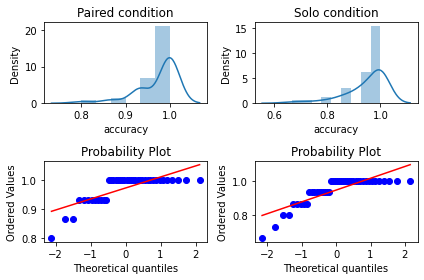

In [10]:
fig,ax = plt.subplots(2,2)
ax[0,0].set_title("Paired condition")
ax[0,1].set_title("Solo condition")
sns.distplot(training_dyads['accuracy'], ax=ax[0,0])
sns.distplot(training_solo['accuracy'], ax=ax[0,1])
stats.probplot(training_dyads['accuracy'], dist="norm", plot=ax[1,0])
stats.probplot(training_solo['accuracy'], dist="norm", plot=ax[1,1])
plt.tight_layout()

In [11]:
stat, p = stats.shapiro(training_dyads['accuracy'])
print('Normality test for accuracy in PAIRED condition')
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Sample is not Gaussian')
else:
    print('Sample is Gaussian')

stat, p = stats.shapiro(training_solo['accuracy'])
print('Normality test for accuracy in SOLO condition')
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Sample is not Gaussian')
else:
    print('Sample is Gaussian')

Normality test for accuracy in PAIRED condition
Statistics=0.618, p=0.000
Sample is not Gaussian
Normality test for accuracy in SOLO condition
Statistics=0.710, p=0.000
Sample is not Gaussian


In [12]:
stat, p = stats.mannwhitneyu(
    training_dyads['accuracy'], 
    training_solo['accuracy']
)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=736.000, p=0.067


**Result of test 1:** Not enough evidence to reject H0. Average accuracy for PAIRED and SOLO conditions in the last 3 training rounds are equal (t(82)=1.824, p=.072, note: non-parametric U test agrees with t-test).

---

**Test 2:** Verify experts' accuracy was mantained during game rounds. 

In [112]:
game_dyads = filter_variables(data, {
    'stage==':'Game rounds', 
    'treatment==':'dyad', 
    'expert_dog==':True}
                                 )[['player','round','accuracy']]
game_dyads = game_dyads.groupby(['player','round'])['accuracy'].mean().reset_index()
print("="*10+"PAIRED EXPERTS"+"="*10)
print("Mean accuracy:", game_dyads['accuracy'].mean())
r, p = stats.pearsonr(game_dyads['accuracy'],game_dyads['round'])
print("Pearson correlation accuracy vs. round:", r)
print("Significance:", p)
print("Number of data points:", game_dyads.shape[0])

print("")

game_solo = filter_variables(data, {
    'stage==':'Game rounds', 
    'treatment==':'single', 
    'expert_dog==':True}
                                 )[['player','round','accuracy']]
game_solo = game_solo.groupby(['player','round'])['accuracy'].mean().reset_index()
print("="*10+"SOLO EXPERTS"+"="*10)
print("Mean accuracy:", game_solo['accuracy'].mean())
r, p = stats.pearsonr(game_solo['accuracy'],game_solo['round'])
print("Pearson correlation accuracy vs. round:", r)
print("Significance:", p)
print("Number of data points:", game_solo.shape[0])


==========PAIRED EXPERTS==========
Mean accuracy: 0.9517488632388947
Pearson correlation accuracy vs. round: 0.03883012231922216
Significance: 0.23107612265211447
Number of data points: 953

==========SOLO EXPERTS==========
Mean accuracy: 0.950031065548307
Pearson correlation accuracy vs. round: 0.06222144512887509
Significance: 0.041573247438934424
Number of data points: 1073


**Result of test 2:** Average accuracy for expert dog classification was maintained around 95\% during game rounds in the paired condition ($\mbox{M}_{paired}\,{=}\,.95$, $\mbox{r}(951)\,{=}\,.04$, $\mbox{p}\,{=}\,.23$) and showed a slight improvement in the solo condition ($\mbox{M}_{solo}\,{=}\,.95$, $\mbox{r}(1071)\,{=}\,.06$, $\mbox{p}\,{=}\,.04$).


---

**Test 3:** Comparison of accuracy of classification of novice dogs during game rounds between paired and solo conditions.

In [16]:
game_dyads_novices = filter_variables(data, {
    'stage==':'Game rounds', 
    'treatment==':'dyad', 
    'expert_dog==':False}
                                 )[['player','accuracy']]
game_dyads_novices = game_dyads_novices.groupby('player').mean().reset_index()
print("="*10+"PAIRED NOVICES"+"="*10)
print('Accuracy mean:', game_dyads_novices['accuracy'].mean())
print('Accuracy standard deviation:', game_dyads_novices['accuracy'].std())
print('Number of data points:', game_dyads_novices['accuracy'].count())

print("")

game_solo_novices = filter_variables(data, {
    'stage==':'Game rounds', 
    'treatment==':'single', 
    'expert_dog==':False}
                                 )[['player','accuracy']]
game_solo_novices = game_solo_novices.groupby('player').mean().reset_index()
print("="*10+"SOLO NOVICES"+"="*10)
print('Accuracy mean:', game_solo_novices['accuracy'].mean())
print('Accuracy standard deviation:', game_solo_novices['accuracy'].std())
print('Number of data points:', game_solo_novices['accuracy'].count())



==========PAIRED NOVICES==========
Accuracy mean: 0.8250516436275526
Accuracy standard deviation: 0.1251700281557308
Number of data points: 40

==========SOLO NOVICES==========
Accuracy mean: 0.796061296806434
Accuracy standard deviation: 0.12638723823212092
Number of data points: 44


In [17]:
stat, p = stats.ttest_ind(game_dyads_novices['accuracy'],game_solo_novices['accuracy'],)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Reject H0: means are not equal.')
else:
    print('Cannot reject H0: means are equal.')

Statistics=1.055, p=0.295
Cannot reject H0: means are equal.


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


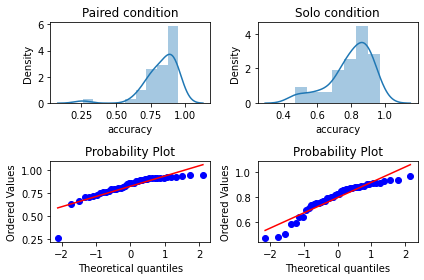

In [18]:
fig,ax = plt.subplots(2,2)
ax[0,0].set_title("Paired condition")
ax[0,1].set_title("Solo condition")
sns.distplot(game_dyads_novices['accuracy'], ax=ax[0,0])
sns.distplot(game_solo_novices['accuracy'], ax=ax[0,1])
stats.probplot(game_dyads_novices['accuracy'], dist="norm", plot=ax[1,0])
stats.probplot(game_solo_novices['accuracy'], dist="norm", plot=ax[1,1])
plt.tight_layout()

In [19]:
stat, p = stats.shapiro(game_dyads_novices['accuracy'])
print('Normality test for accuracy in PAIRED condition')
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Sample is not Gaussian')
else:
    print('Sample is Gaussian')

stat, p = stats.shapiro(game_solo_novices['accuracy'])
print('Normality test for accuracy in SOLO condition')
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Sample is not Gaussian')
else:
    print('Sample is Gaussian')

Normality test for accuracy in PAIRED condition
Statistics=0.767, p=0.000
Sample is not Gaussian
Normality test for accuracy in SOLO condition
Statistics=0.891, p=0.001
Sample is not Gaussian


In [20]:
stat, p = stats.mannwhitneyu(
    game_dyads_novices['accuracy'], 
    game_solo_novices['accuracy']
)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=741.000, p=0.107


**Result of test 3:** Paired novices did a slightly better job than solo novices ($\mbox{M}_{\mbox{paired}}\,{=}\,.83$, $\mbox{SD}_{\mbox{paired}}\,{=}\,.13$, $\mbox{M}_{\mbox{solo}}\,{=}\,.80$, $\mbox{SD}_{\mbox{solo}}\,{=}\,.13$), although this difference is not statistically significant ($\mbox{t}(82)\,{=}\,1.06$, $\mbox{p}\,{=}\,.30$, note: non-parametric U test agrees with t-test). 

---

**Test 4:** Check whether novices who send more queries are more accurate.

In [21]:
game_dyads_novices = filter_variables(data, {
    'stage==':'Game rounds', 
    'treatment==':'dyad', 
    'expert_dog==':False}
                                 )[['player','kind','accuracy','queried']]
game_dyads_novices['queried'] = game_dyads_novices['queried'].apply(lambda x: 0 if np.isnan(x) else x)
game_dyads_novices = game_dyads_novices.groupby(['player','kind']).agg({'accuracy':'mean', 'queried':'mean'}).reset_index()
game_dyads_novices.head()


,player,kind,accuracy,queried
0,21409433577947,B,0.828571,0.800000
1,21409433577947,D,0.571429,0.952381
2,32111755046981,A,0.678571,0.107143
3,32111755046981,C,0.757576,0.090909
4,38174543864515,B,0.888889,0.555556


<AxesSubplot:xlabel='queried', ylabel='accuracy'>

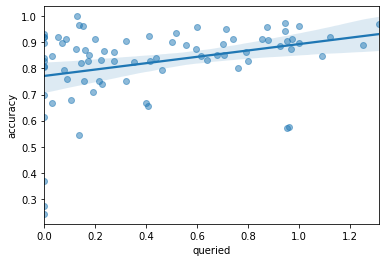

In [22]:
sns.regplot(x='queried', y='accuracy', data=game_dyads_novices, scatter_kws={'alpha':0.5})


In [23]:
print("="*10+"PAIRED NOVICES"+"="*10)
print('Accuracy mean:', game_dyads_novices['accuracy'].mean())
print('Queried mean:', game_dyads_novices['queried'].mean())
r, p = stats.pearsonr(game_dyads_novices['accuracy'],game_dyads_novices['queried'])
print("Pearson correlation accuracy vs. queried:", r)
print("Significance:", p)
print("Number of data points:", game_dyads_novices.shape[0])



==========PAIRED NOVICES==========
Accuracy mean: 0.8235935238451454
Queried mean: 0.4289333446043351
Pearson correlation accuracy vs. queried: 0.32077129615103184
Significance: 0.0037198785768619365
Number of data points: 80


**Result of test 4:** Novices who tended to send more queries were more likely to be accurate ($\mbox{r}(78)\,{=}\,.32$, $\mbox{p}\,{<}\,.01$).

---

**Test 5:** Self-report of understanding compared between paired and solo conditions.

In [24]:
report_dyads = filter_variables(report_understanding, {
    'treatment==':'dyad', 
    'expertise==':'experts'}
                                 )[['player','report']]
print("="*10+"PAIRED condition"+"="*10)
print('Accuracy mean:', report_dyads['report'].mean())
print('Accuracy standard deviation:', report_dyads['report'].std())
print('Number of data points:', report_dyads['report'].count())
print('Lost 1 player observation due to error in saving data in nodeGame')

print("")

report_solo = filter_variables(report_understanding, {
    'treatment==':'single', 
    'expertise==':'experts'}
                                 )[['player','report']]
print("="*10+"SOLO condition"+"="*10)
print('Accuracy mean:', report_solo['report'].mean())
print('Accuracy standard deviation:', report_solo['report'].std())
print('Number of data points:', report_solo['report'].count())



==========PAIRED condition==========
Accuracy mean: 6.217948717948718
Accuracy standard deviation: 1.1124728030813775
Number of data points: 78
Lost 1 player observation due to error in saving data in nodeGame

==========SOLO condition==========
Accuracy mean: 5.318181818181818
Accuracy standard deviation: 1.3090792986829847
Number of data points: 88


In [25]:
stat, p = stats.ttest_ind(report_dyads['report'],report_solo['report'],)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Reject H0: means are not equal.')
else:
    print('Cannot reject H0: means are equal.')

Statistics=4.740, p=0.000
Reject H0: means are not equal.


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


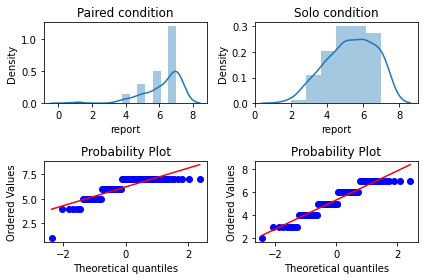

In [26]:
fig,ax = plt.subplots(2,2)
ax[0,0].set_title("Paired condition")
ax[0,1].set_title("Solo condition")
sns.distplot(report_dyads['report'], ax=ax[0,0])
sns.distplot(report_solo['report'], ax=ax[0,1])
stats.probplot(report_dyads['report'], dist="norm", plot=ax[1,0])
stats.probplot(report_solo['report'], dist="norm", plot=ax[1,1])
plt.tight_layout()

In [27]:
stat, p = stats.shapiro(report_dyads['report'])
print('Normality test for accuracy in PAIRED condition')
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Sample is not Gaussian')
else:
    print('Sample is Gaussian')

stat, p = stats.shapiro(report_solo['report'])
print('Normality test for accuracy in SOLO condition')
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Sample is not Gaussian')
else:
    print('Sample is Gaussian')

Normality test for accuracy in PAIRED condition
Statistics=0.717, p=0.000
Sample is not Gaussian
Normality test for accuracy in SOLO condition
Statistics=0.909, p=0.000
Sample is not Gaussian


In [28]:
stat, p = stats.mannwhitneyu(
    report_dyads['report'], 
    report_solo['report']
)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=2016.500, p=0.000


**Result of test 4:** Paired participants reported on average a greater understanding of their expert dogs than solo participants ($\mbox{M}_{\mbox{paired experts}}\,{=}\,6.22$, $\mbox{SD}_{\mbox{paired experts}}\,{=}\,1.11$, $\mbox{M}_{\mbox{solo experts}}\,{=}\,5.32$, $\mbox{SD}_{\mbox{solo experts}}\,{=}\,1.31$, $\mbox{t}(164)\,{=}\,4.74$, $\mbox{p}\,{<}\,.001$, note: non-parametric U test agrees with t-test).

---

**Test 5:** Correlation between *expert* accuracy and report, per condition.

As it turns out, there is a player who, albeit being an expert, reported a very low understanding and very low accuracy for one of their expert dog breeds. We will treat this data point as an outlier and will leave it out of the present analysis. Here is a visual presentation of such an outlier.

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seab

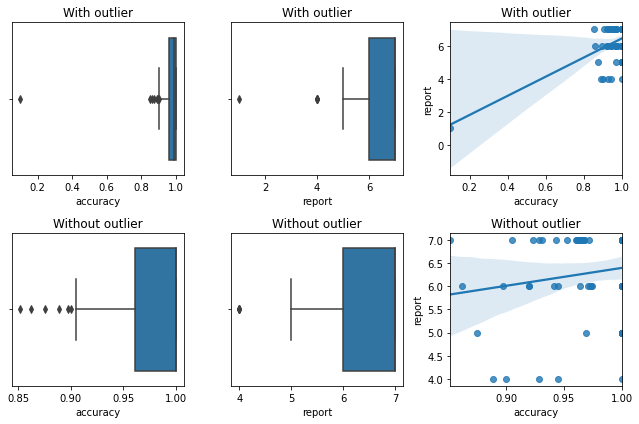

In [124]:
report_dyads = filter_variables(report_understanding, {
    'treatment==':'dyad', 
    'expertise==':'experts'}
                                 )[['player','report','accuracy']]
fig, ax = plt.subplots(2,3,figsize=(9,6))
sns.boxplot(report_dyads['accuracy'], ax=ax[0,0])
sns.boxplot(report_dyads['report'], ax=ax[0,1])
sns.regplot(x='accuracy', y='report', data=report_dyads, ax=ax[0,2])
ax[0,0].set_title("With outlier")
ax[0,1].set_title("With outlier")
ax[0,2].set_title("With outlier")

report_dyads = report_dyads[report_dyads['accuracy']>0.25]

sns.boxplot(report_dyads['accuracy'], ax=ax[1,0])
sns.boxplot(report_dyads['report'], ax=ax[1,1])
sns.regplot(x='accuracy', y='report', data=report_dyads, ax=ax[1,2])
ax[1,0].set_title("Without outlier")
ax[1,1].set_title("Without outlier")
ax[1,2].set_title("Without outlier")

plt.tight_layout()


In [125]:
print("="*10+"PAIRED EXPERTS"+"="*10)
print("Mean accuracy:", report_dyads['accuracy'].mean())
print("Mean report:", report_dyads['report'].mean())
r, p = stats.pearsonr(report_dyads['accuracy'],report_dyads['report'])
print("Pearson correlation accuracy vs. report:", r)
print("Significance:", p)
print("Number of data points:", report_dyads.shape[0])

print("")

report_solo = filter_variables(report_understanding, {
    'treatment==':'single', 
    'expertise==':'experts'}
                                 )[['player','report','accuracy']]
print("="*10+"SOLO EXPERTS"+"="*10)
print("Mean accuracy:", report_solo['accuracy'].mean())
print("Mean report:", report_solo['report'].mean())
r, p = stats.pearsonr(report_solo['accuracy'],report_solo['report'])
print("Pearson correlation accuracy vs. report:", r)
print("Significance:", p)
print("Number of data points:", report_solo.shape[0])

==========PAIRED EXPERTS==========
Mean accuracy: 0.9713775372631759
Mean report: 6.285714285714286
Pearson correlation accuracy vs. report: 0.15330026227343121
Significance: 0.18316109288082444
Number of data points: 77

==========SOLO EXPERTS==========
Mean accuracy: 0.9533899636180259
Mean report: 5.318181818181818
Pearson correlation accuracy vs. report: 0.3030936166375192
Significance: 0.0040986878971194865
Number of data points: 88


Text(0.5, 1.0, 'Single')

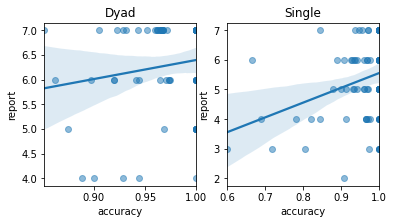

In [126]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
sns.regplot(x='accuracy', y='report', data=report_dyads, scatter_kws={'alpha':0.5}, ax=ax[0])
sns.regplot(x='accuracy', y='report', data=report_solo, scatter_kws={'alpha':0.5}, ax=ax[1])
ax[0].set_title('Dyad')
ax[1].set_title('Single')

**Result of test 5:** Accuracy does not make a significant contribution to the report for dyadic experts ($\mbox{r}(75)\,{=}\,.15$, $\mbox{p}\,{=}\,.18$) as compared to a significant influence in the solo condition ($\mbox{r}(86)\,{=}\,.3$, $\mbox{p}\,{<}\,.01$).

---

**Test 6:** Correlation of *novice* accuracy and report, per condition.

In [130]:
report_dyads = filter_variables(report_understanding, {
    'treatment==':'dyad', 
    'expertise==':'novices'}
                                 )[['player','report','accuracy']]
print("="*10+"PAIRED NOVICES"+"="*10)
print("Mean accuracy:", report_dyads['accuracy'].mean())
print("Mean report:", report_dyads['report'].mean())
r, p = stats.pearsonr(report_dyads['accuracy'],report_dyads['report'])
print("Pearson correlation accuracy vs. report:", r)
print("Significance:", p)
print("Number of data points:", report_dyads.shape[0])

print("")

report_solo = filter_variables(report_understanding, {
    'treatment==':'single', 
    'expertise==':'novices'}
                                 )[['player','report','accuracy']]
print("="*10+"SOLO NOVICES"+"="*10)
print("Mean accuracy:", report_solo['accuracy'].mean())
print("Mean report:", report_solo['report'].mean())
r, p = stats.pearsonr(report_solo['accuracy'],report_solo['report'])
print("Pearson correlation accuracy vs. report:", r)
print("Significance:", p)
print("Number of data points:", report_solo.shape[0])


==========PAIRED NOVICES==========
Mean accuracy: 0.8381067999033346
Mean report: 4.17948717948718
Pearson correlation accuracy vs. report: 0.06961765259716843
Significance: 0.5447437158379747
Number of data points: 78

==========SOLO NOVICES==========
Mean accuracy: 0.7960952725706538
Mean report: 4.443181818181818
Pearson correlation accuracy vs. report: 0.2623726030412069
Significance: 0.013529858797802063
Number of data points: 88


**Result of test 6:** For solo novices, the report is highly correlated with accuracy ($\mbox{r}(88)\,{=}\,.26$, $\mbox{p}\,{=}\,.01$). But for paired novices the correlation is very low and not statistically significant ($\mbox{r}(76)\,{=}\,.07$, $\mbox{p}\,{=}\,.54$).

---

**Test 7:** Regression model of report with respect to accuracy, # of queries, and rate of queries answered by expert partner.

In [153]:
df_expertos_parejas = filter_variables(report_understanding, {
    'treatment==':'dyad', 
    'expertise==':'experts'}
                                 )[['player','report','accuracy','player_responded']]
df_expertos_parejas = df_expertos_parejas[df_expertos_parejas['accuracy']>0.2]
df_expertos_parejas = df_expertos_parejas[df_expertos_parejas['player_responded'].isna()==False]

In [156]:
model = ols("report ~ accuracy + player_responded", data=df_expertos_parejas)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 report   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     2.864
Date:                Fri, 11 Jun 2021   Prob (F-statistic):             0.0646
Time:                        15:34:49   Log-Likelihood:                -87.056
No. Observations:                  65   AIC:                             180.1
Df Residuals:                      62   BIC:                             186.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.6873      2.947      0.573      0.569      -4.204       7.578
accuracy             3.6873      3.039      1.213      0.230      -2.388       9.763
player_responded     1.1090      0.570      1.945      0.056      -0.031       2.249
==============================================================================
Omnibus:                        7.369   Durbin-Watson:                   1.414
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.582
Skew:                          -0.802   Prob(JB):                       0.0226
Kurtosis:                       2.521   Cond. No.                         59.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
model = ols("report ~ accuracy + queried + answered", data=df_expertos_parejas)
results = model.fit()
results.summary()

/usr/local/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 report   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     10.41
Date:                Fri, 11 Jun 2021   Prob (F-statistic):             0.0428
Time:                        15:05:29   Log-Likelihood:                -6.2267
No. Observations:                   7   AIC:                             20.45
Df Residuals:                       3   BIC:                             20.24
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9757      5.799      0.858      0.454     -13.478      23.430
accuracy       5.8083      1.166      4.980      0.016       2.096       9.520
queried       -0.3203      0.882     -0.363      0.741      -3.129       2.488
answered      -4.1906      4.924     -0.851      0.457     -19.860      11.479
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.650
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.544
Skew:                          -1.125   Prob(JB):                        0.462
Kurtosis:                       3.486   Cond. No.                         55.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Results of test 7:** When regressing the report with respect to accuracy and response rate, we observe that the accuracy coefficient is not significant ($\mbox{B}_{\mbox{ accuracy}}\,{=}\,3.69$, $\mbox{p}_{\mbox{ accuracy}}\,{=}\,.23$). However, the contribution of the response rate is borderline significant ($\mbox{B}_{\mbox{ response rate}}\,{=}\,1.11$, $\mbox{p}_{\mbox{ response rate}}\,{=}\,.056$).

---

**Test 8:** Regression model of report with respect to accuracy, # of queries, and rate of queries answered by expert partner.

In [131]:
df_novatos_parejas = filter_variables(report_understanding, {
    'treatment==':'dyad', 
    'expertise==':'novices'}
                                 )[['player','report','accuracy','queried','answered']]

In [132]:
model = ols("report ~ accuracy + queried + answered", data=df_novatos_parejas)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 report   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.841
Date:                Fri, 11 Jun 2021   Prob (F-statistic):              0.149
Time:                        14:17:31   Log-Likelihood:                -116.71
No. Observations:                  67   AIC:                             241.4
Df Residuals:                      63   BIC:                             250.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6953      1.686      2.784      0.007       1.325       8.065
accuracy       1.2261      1.856      0.661      0.511      -2.483       4.936
queried        0.0040      0.020      0.195      0.846      -0.037       0.045
answered      -1.8735      0.860     -2.178      0.033      -3.592      -0.155
==============================================================================
Omnibus:                        1.177   Durbin-Watson:                   0.977
Prob(Omnibus):                  0.555   Jarque-Bera (JB):                0.552
Skew:                           0.033   Prob(JB):                        0.759
Kurtosis:                       3.440   Cond. No.                         243.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Result test 8:** The regression coefficients for the first two variables are not significant ($\mbox{B}_{\mbox{ accuracy}}\,{=}\,1.23$, $\mbox{p}_{\mbox{ accuracy}}\,{=}\,.51$, $\mbox{B}_{\mbox{ queries}}\,{=}\,.004$, $\mbox{p}_{\mbox{ queries}}\,{=}\,.85$) while the coefficient for the third is negative and significant ($\mbox{B}_{\mbox{ answered}}\,{=}\,-1.87$, $\mbox{p}_{\mbox{ answered}}\,{=}\,.03$).

---

### Figures <a class="anchor" id="figures"></a>

**Figure 4:**

In [34]:
data_training = data[data['stage']=='Training rounds'][['treatment', 'player', 'round', 'accuracy']]
data_game = data[data['stage']=='Game rounds']
data_game['tipo_ejemplar'] = data_game['kind'].apply(lambda x: 'terrier' if (x=='A' or x=='C') else 'hound')
dfN = data_game[(data_game['novice_in'] == data_game['tipo_ejemplar'])]
dfE = data_game[(data_game['expert_in'] == data_game['tipo_ejemplar'])]


<ipython-input-34-eb1981697635>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_game['tipo_ejemplar'] = data_game['kind'].apply(lambda x: 'terrier' if (x=='A' or x=='C') else 'hound')


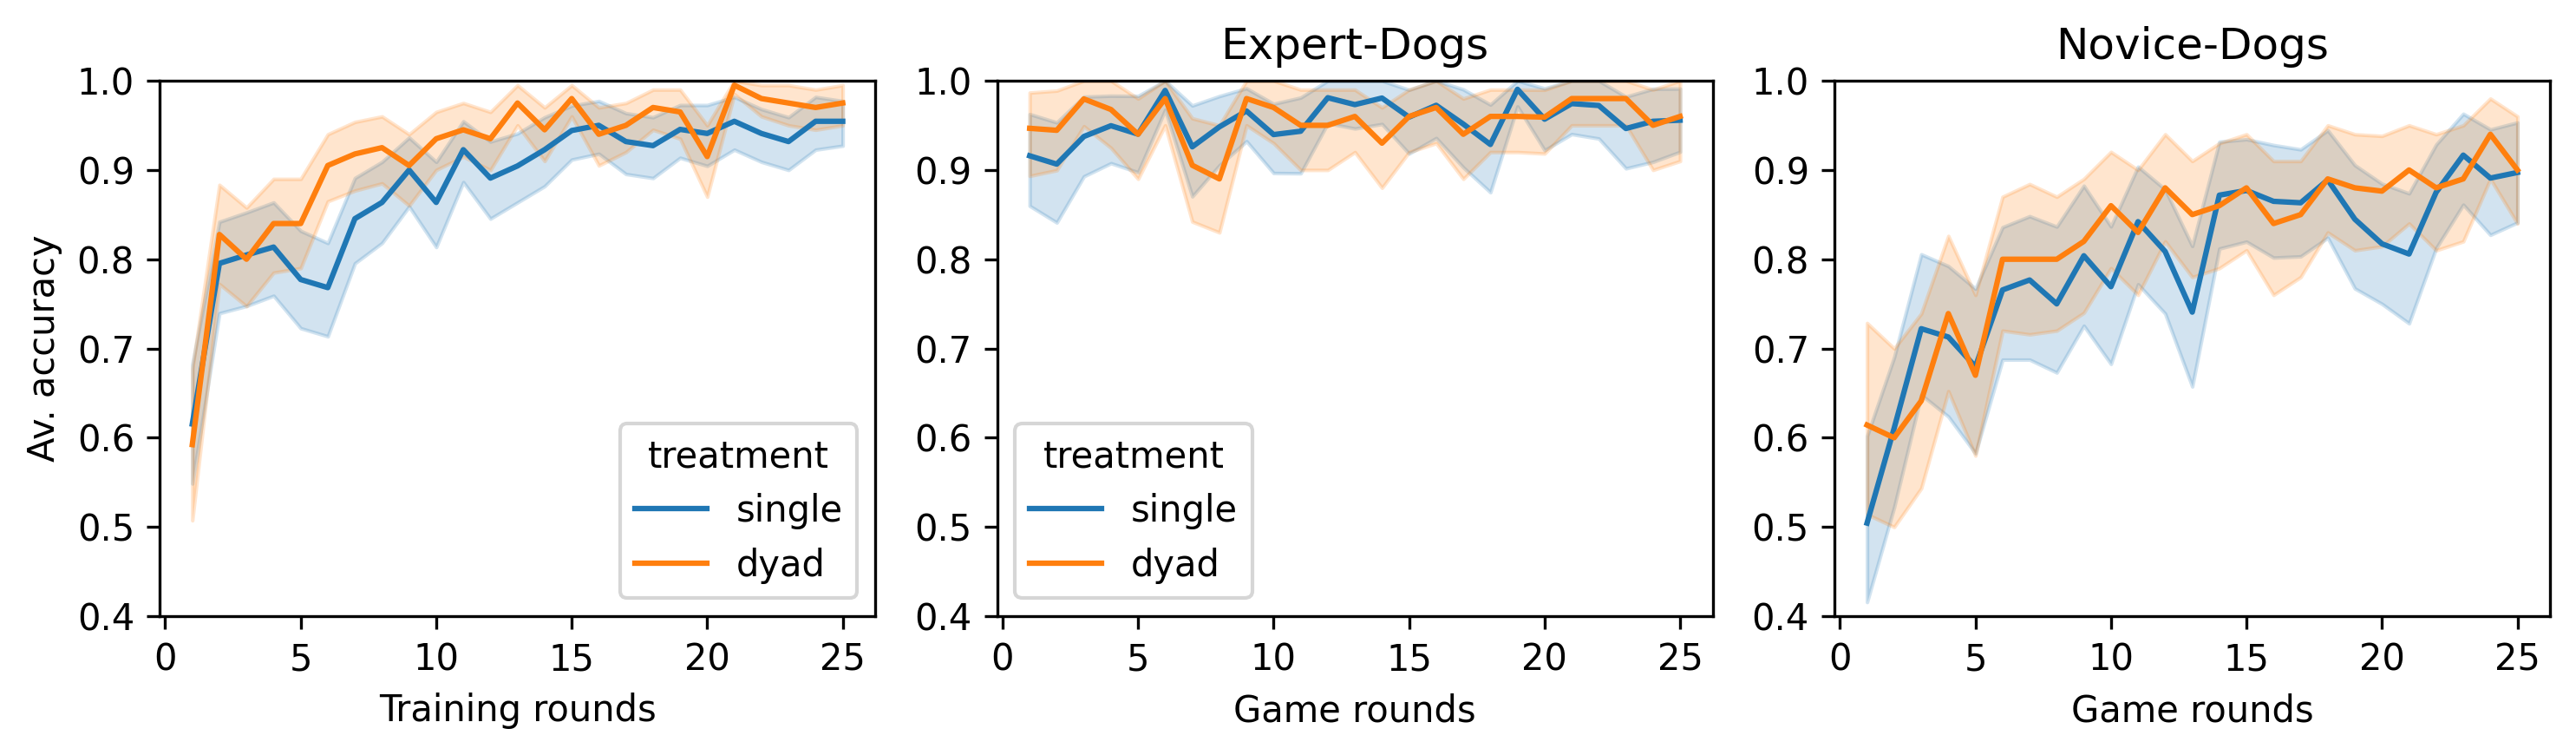

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(10,3), dpi=300)
sns.lineplot(x='round', y='accuracy', hue='treatment', data=data_training, ci=95, ax=ax[0])
sns.lineplot(x='round', y='accuracy', hue='treatment', data=dfE, ci=95, ax=ax[1])
sns.lineplot(x='round', y='accuracy', hue='treatment', data=dfN, ci=95, ax=ax[2])
ax[0].set_ylim(0.4, 1)
ax[0].set_xlabel('Training rounds')
ax[0].set_ylabel('Av. accuracy')
ax[0].set_ylim(0.4, 1)
ax[1].set_title("Expert-Dogs")
ax[1].set_xlabel("Game rounds")
ax[1].set_ylabel('')
ax[1].set_ylim(0.4, 1)
ax[2].set_title("Novice-Dogs")
ax[2].set_xlabel("Game rounds")
ax[2].set_ylabel("")
ax[2].set_ylim(0.4, 1)
ax[2].get_legend().remove()

fig.tight_layout()


In [36]:
fig.savefig('figura4.pdf', dpi=300)

----

**Figure 5:**

In [37]:
dict_razas = {'A':'Cairn\n Terrier', 'C':'Norwich\n Terrier', 'B':'Irish\n Wolf\nhound', 'D':'Scottish\n Deer\nhound'}
dict_orden = {'A':1, 'C':2, 'B':3, 'D':4}

In [38]:
df = pd.DataFrame(data[(data['treatment']=='dyad') & (data['stage']=='Game rounds')])
df['query'] = ['Yes' if x>0 else 'No' for x in df['queried']]
df = df.groupby(['novice_in', 'kind'])['query'].value_counts(dropna=False, normalize=True).reset_index(name='pregunta')
df = df[df['query']=='Yes']
del df['query']
df.columns = ['Novice in', 'kind', 'query']
df['query'] = df['query']*100
df['indice'] = df['kind'].map(dict_orden)
df['kind'] = df['kind'].map(dict_razas)
df.sort_values(by='indice', inplace=True)
del df['indice']
df_preguntas = df
df_preguntas

,Novice in,kind,query
1,hound,Cairn\n Terrier,1.121795
9,terrier,Cairn\n Terrier,40.000000
5,hound,Norwich\n Terrier,0.496689
12,terrier,Norwich\n Terrier,38.907285
3,hound,Irish\n Wolf\nhound,38.888889
7,hound,Scottish\n Deer\nhound,37.288136
14,terrier,Scottish\n Deer\nhound,0.333333


In [39]:
df = data.groupby('kind')['answered'].mean().reset_index()
df['indice'] = df['kind'].map(dict_orden)
df['kind'] = df['kind'].map(dict_razas)
df.sort_values(by='indice', inplace=True)
del df['indice']
df.columns = ['kind', 'answered']
df_respondido = df
df_respondido.head()


,kind,answered
0,Cairn\n Terrier,0.936293
2,Norwich\n Terrier,0.964286
1,Irish\n Wolf\nhound,0.972689
3,Scottish\n Deer\nhound,0.907658


In [40]:
df = data.groupby('kind')['accuracy'].mean().reset_index()
df['indice'] = df['kind'].map(dict_orden)
df['kind'] = df['kind'].map(dict_razas)
df.sort_values(by='indice', inplace=True)
del df['indice']
df.columns = ['kind', 'correct']
df_correcto = df
df_correcto.head()


,kind,correct
0,Cairn\n Terrier,0.866976
2,Norwich\n Terrier,0.910685
1,Irish\n Wolf\nhound,0.889389
3,Scottish\n Deer\nhound,0.900467


In [41]:
df_respuestas = pd.merge(df_respondido, df_correcto, on='kind')
df_respuestas

,kind,answered,correct
0,Cairn\n Terrier,0.936293,0.866976
1,Norwich\n Terrier,0.964286,0.910685
2,Irish\n Wolf\nhound,0.972689,0.889389
3,Scottish\n Deer\nhound,0.907658,0.900467


In [42]:
reporte_comprension_novatos = reporte_comprension[(reporte_comprension['expertise']=='novices') & (reporte_comprension['treatment']=='dyad')]
reporte_comprension_novatos.head()


NameError: name 'reporte_comprension' is not defined

In [43]:
df_msgs = pd.DataFrame(data[(data['treatment']=='dyad') & (data['stage']=='Game rounds')])
df_msgs['kind_dog'] = ['terrier' if (x=='A') or (x=='C') else 'hound' for x in df_msgs['kind']]
df_msgs = pd.DataFrame(df_msgs[(df_msgs['novice_in']==df_msgs['kind_dog'])])
df_msgs['queried'] = [x if x>0 else 0 for x in df_msgs['queried']]
df_msgs = df_msgs.groupby(['player', 'round'])['queried'].mean().reset_index(name='#msg')
df_msgs.head()


,player,round,#msg
0,21409433577947,3,0.666667
1,21409433577947,4,0.666667
2,21409433577947,5,1.000000
3,21409433577947,6,1.000000
4,21409433577947,7,3.000000


In [44]:
game_dyads_novices = filter_variables(data, {
    'stage==':'Game rounds', 
    'treatment==':'dyad', 
    'expert_dog==':False}
                                 )[['player','kind','accuracy','queried']]
game_dyads_novices['queried'] = game_dyads_novices['queried'].apply(lambda x: 0 if np.isnan(x) else x)
game_dyads_novices = game_dyads_novices.groupby(['player','kind']).agg({'accuracy':'mean', 'queried':'mean'}).reset_index()
game_dyads_novices.head()

,player,kind,accuracy,queried
0,21409433577947,B,0.828571,0.800000
1,21409433577947,D,0.571429,0.952381
2,32111755046981,A,0.678571,0.107143
3,32111755046981,C,0.757576,0.090909
4,38174543864515,B,0.888889,0.555556


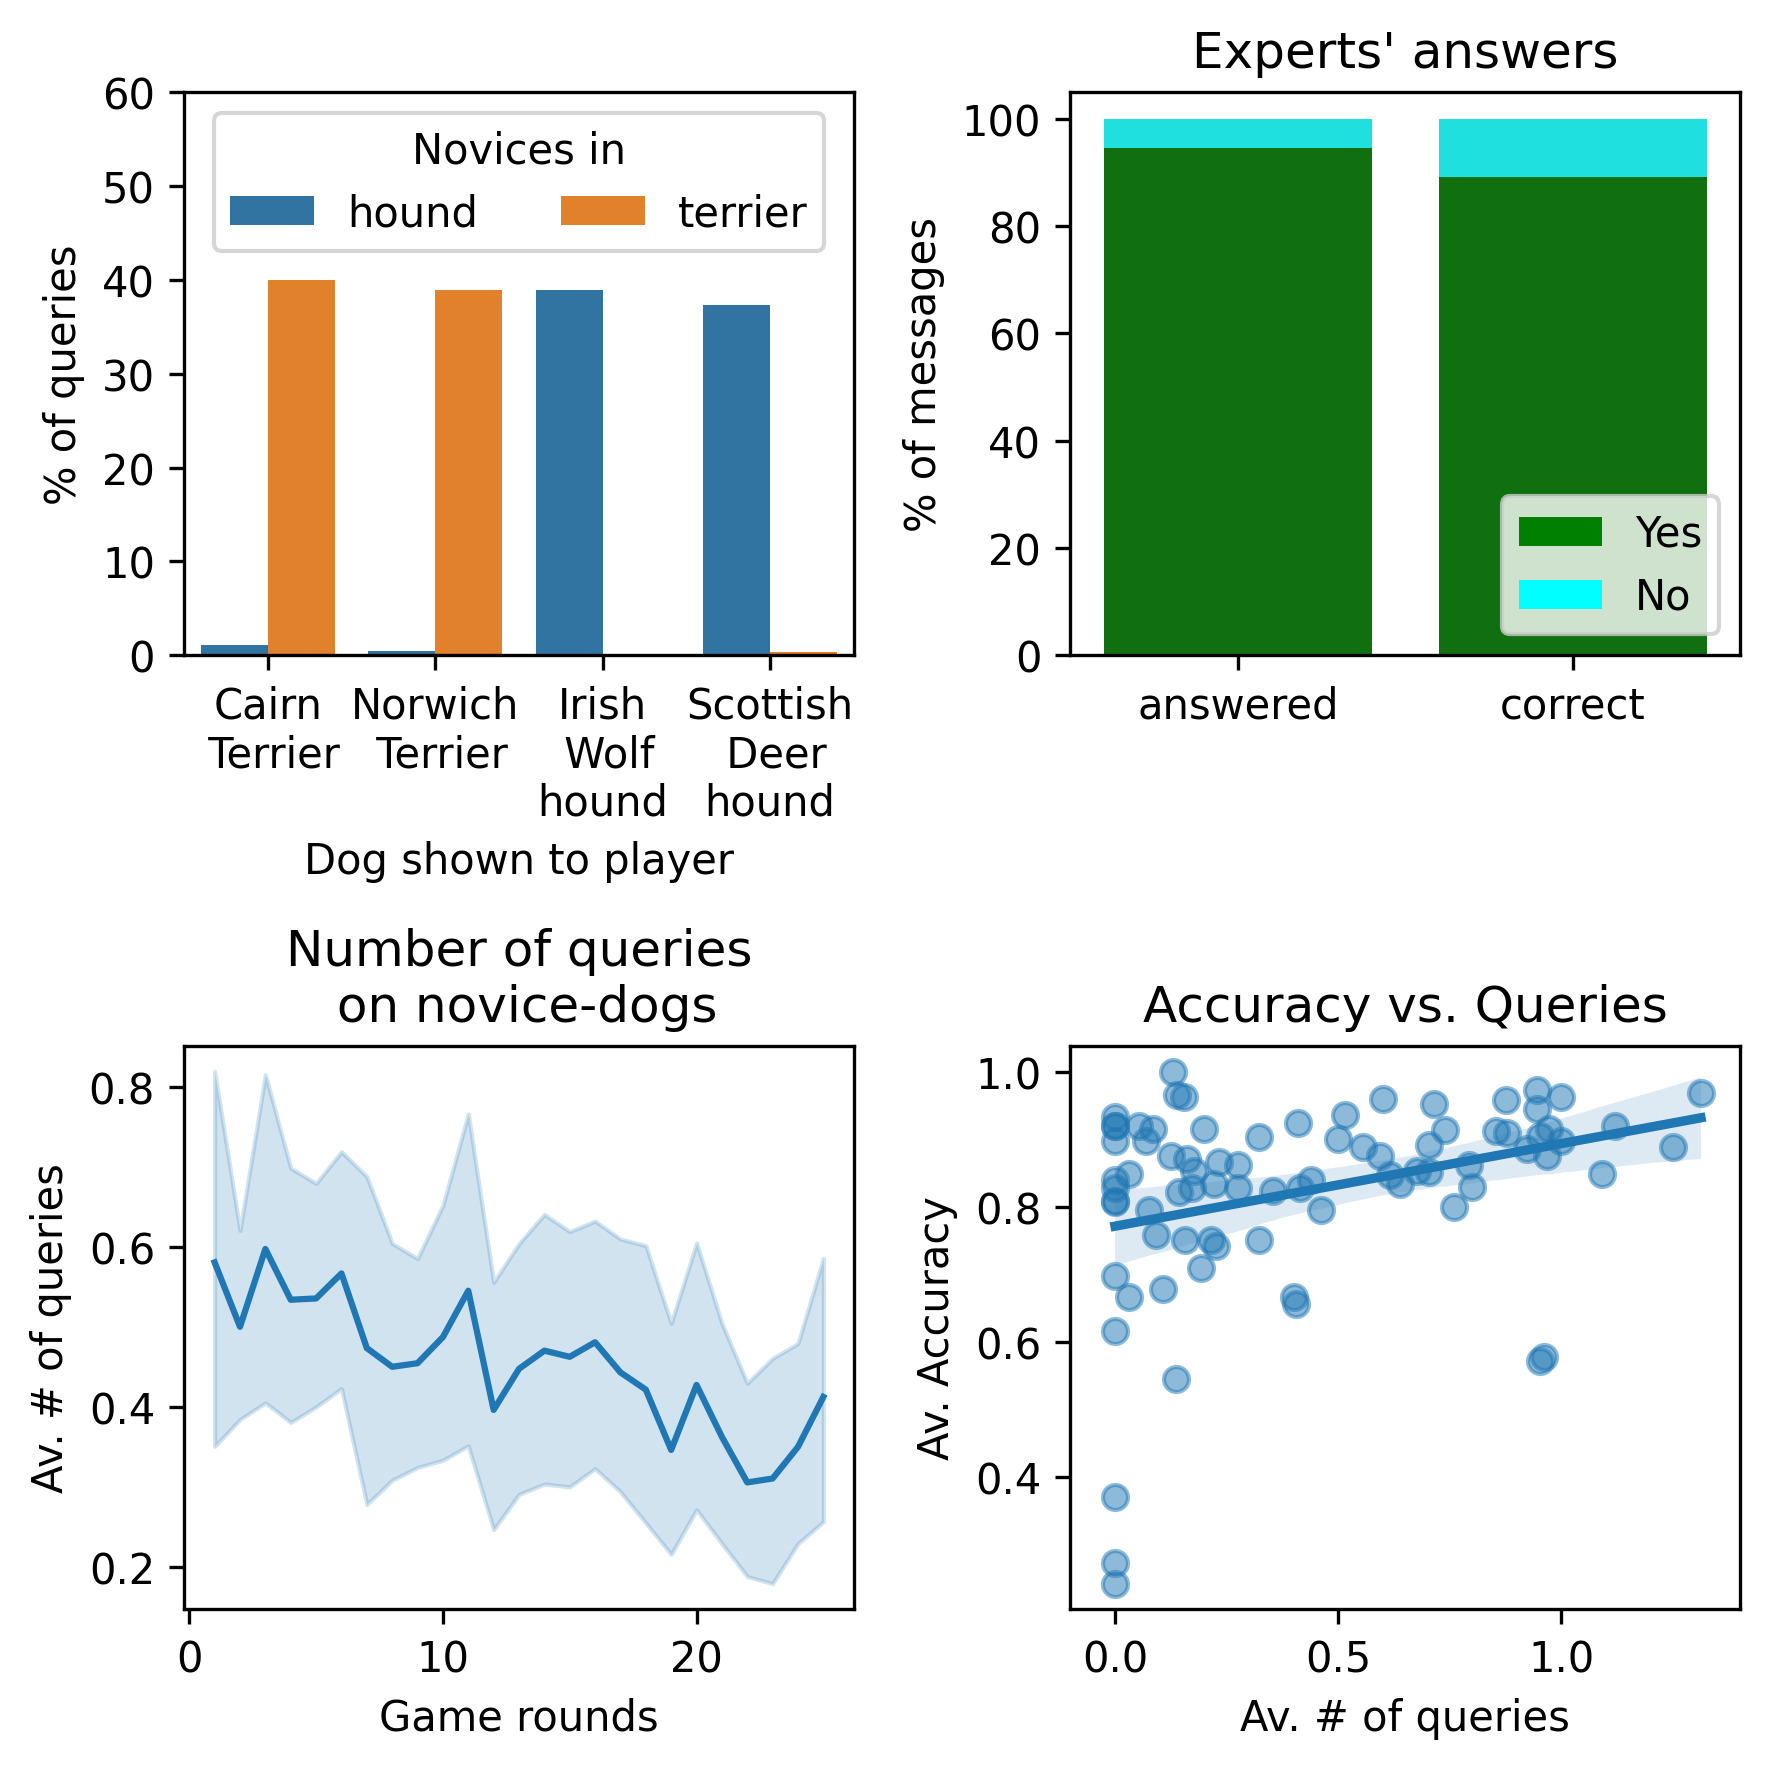

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=300)

sns.barplot(x='kind', y='query', hue='Novice in', data=df_preguntas, ax=ax[0, 0])
ax[0, 0].set_xlabel("Dog shown to player")
ax[0, 0].set(ylim=(0, 60))
ax[0, 0].set_ylabel("% of queries")
ax[0, 0].legend(title="Novices in", ncol=2, loc='upper center')#bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

respondido = df_respuestas['answered'].mean()
correcto = df_respuestas['correct'].mean()
sns.barplot(x=['answered', 'correct'], y=[100, 100], color = "cyan", ax=ax[0, 1])
sns.barplot(x=['answered', 'correct'], y=[respondido*100, correcto*100], color = "green", ax=ax[0, 1])
ax[0, 1].set_title("Experts' answers")
ax[0, 1].set_ylabel("% of messages")
topbar = plt.Rectangle((0,0),1,1,fc="cyan", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='green',  edgecolor = 'none')
ax[0, 1].legend([bottombar, topbar], ['Yes', 'No'], loc='lower right', ncol = 1, prop={'size':10})

sns.lineplot(x='round', y='#msg', data=df_msgs, ax=ax[1, 0], ci=95)
ax[1, 0].set_xlabel("Game rounds")
#ax[1, 0].set(ylim=(0, 2))
ax[1, 0].set_ylabel("Av. # of queries")
ax[1, 0].set_title("Number of queries\n on novice-dogs")

sns.regplot(x='queried', y='accuracy', data=game_dyads_novices, scatter_kws={'alpha':0.5}, ax=ax[1, 1])
ax[1, 1].set_title('Accuracy vs. Queries')
ax[1, 1].set_xlabel('Av. # of queries')
ax[1, 1].set_ylabel('Av. Accuracy')
ax[1, 1].set(xlim=(-0.1, 1.4))

fig.tight_layout()


In [46]:
fig.savefig('figura5.pdf', dpi=300)

---

**Figure 6:**

In [157]:
reporte_comprension = report_understanding
reporte_comprension_expertos = filter_variables(report_understanding, {'expertise==':'experts'})
reporte_comprension_expertos.head()

,treatment,player,kind,expertise,report,accuracy,queried,answered,player_responded
0,dyad,21409433577947,A,experts,7.0,0.931034,2,0.75,0.941176
2,dyad,21409433577947,C,experts,1.0,0.100000,1,1.00,0.888889
5,dyad,32111755046981,B,experts,6.0,0.897436,0,NaN,1.000000
7,dyad,32111755046981,D,experts,6.0,0.920000,1,1.00,NaN
8,dyad,38174543864515,A,experts,4.0,0.888889,0,NaN,1.000000


In [158]:
# Leave out outlier
reporte_comprension_expertos = reporte_comprension_expertos[reporte_comprension_expertos['accuracy']>0.2]

In [159]:
reporte_comprension_expertos_parejas = pd.DataFrame(reporte_comprension_expertos[reporte_comprension_expertos['treatment']=='dyad'])
reporte_comprension_expertos_individual = pd.DataFrame(reporte_comprension_expertos[reporte_comprension_expertos['treatment']=='single'])

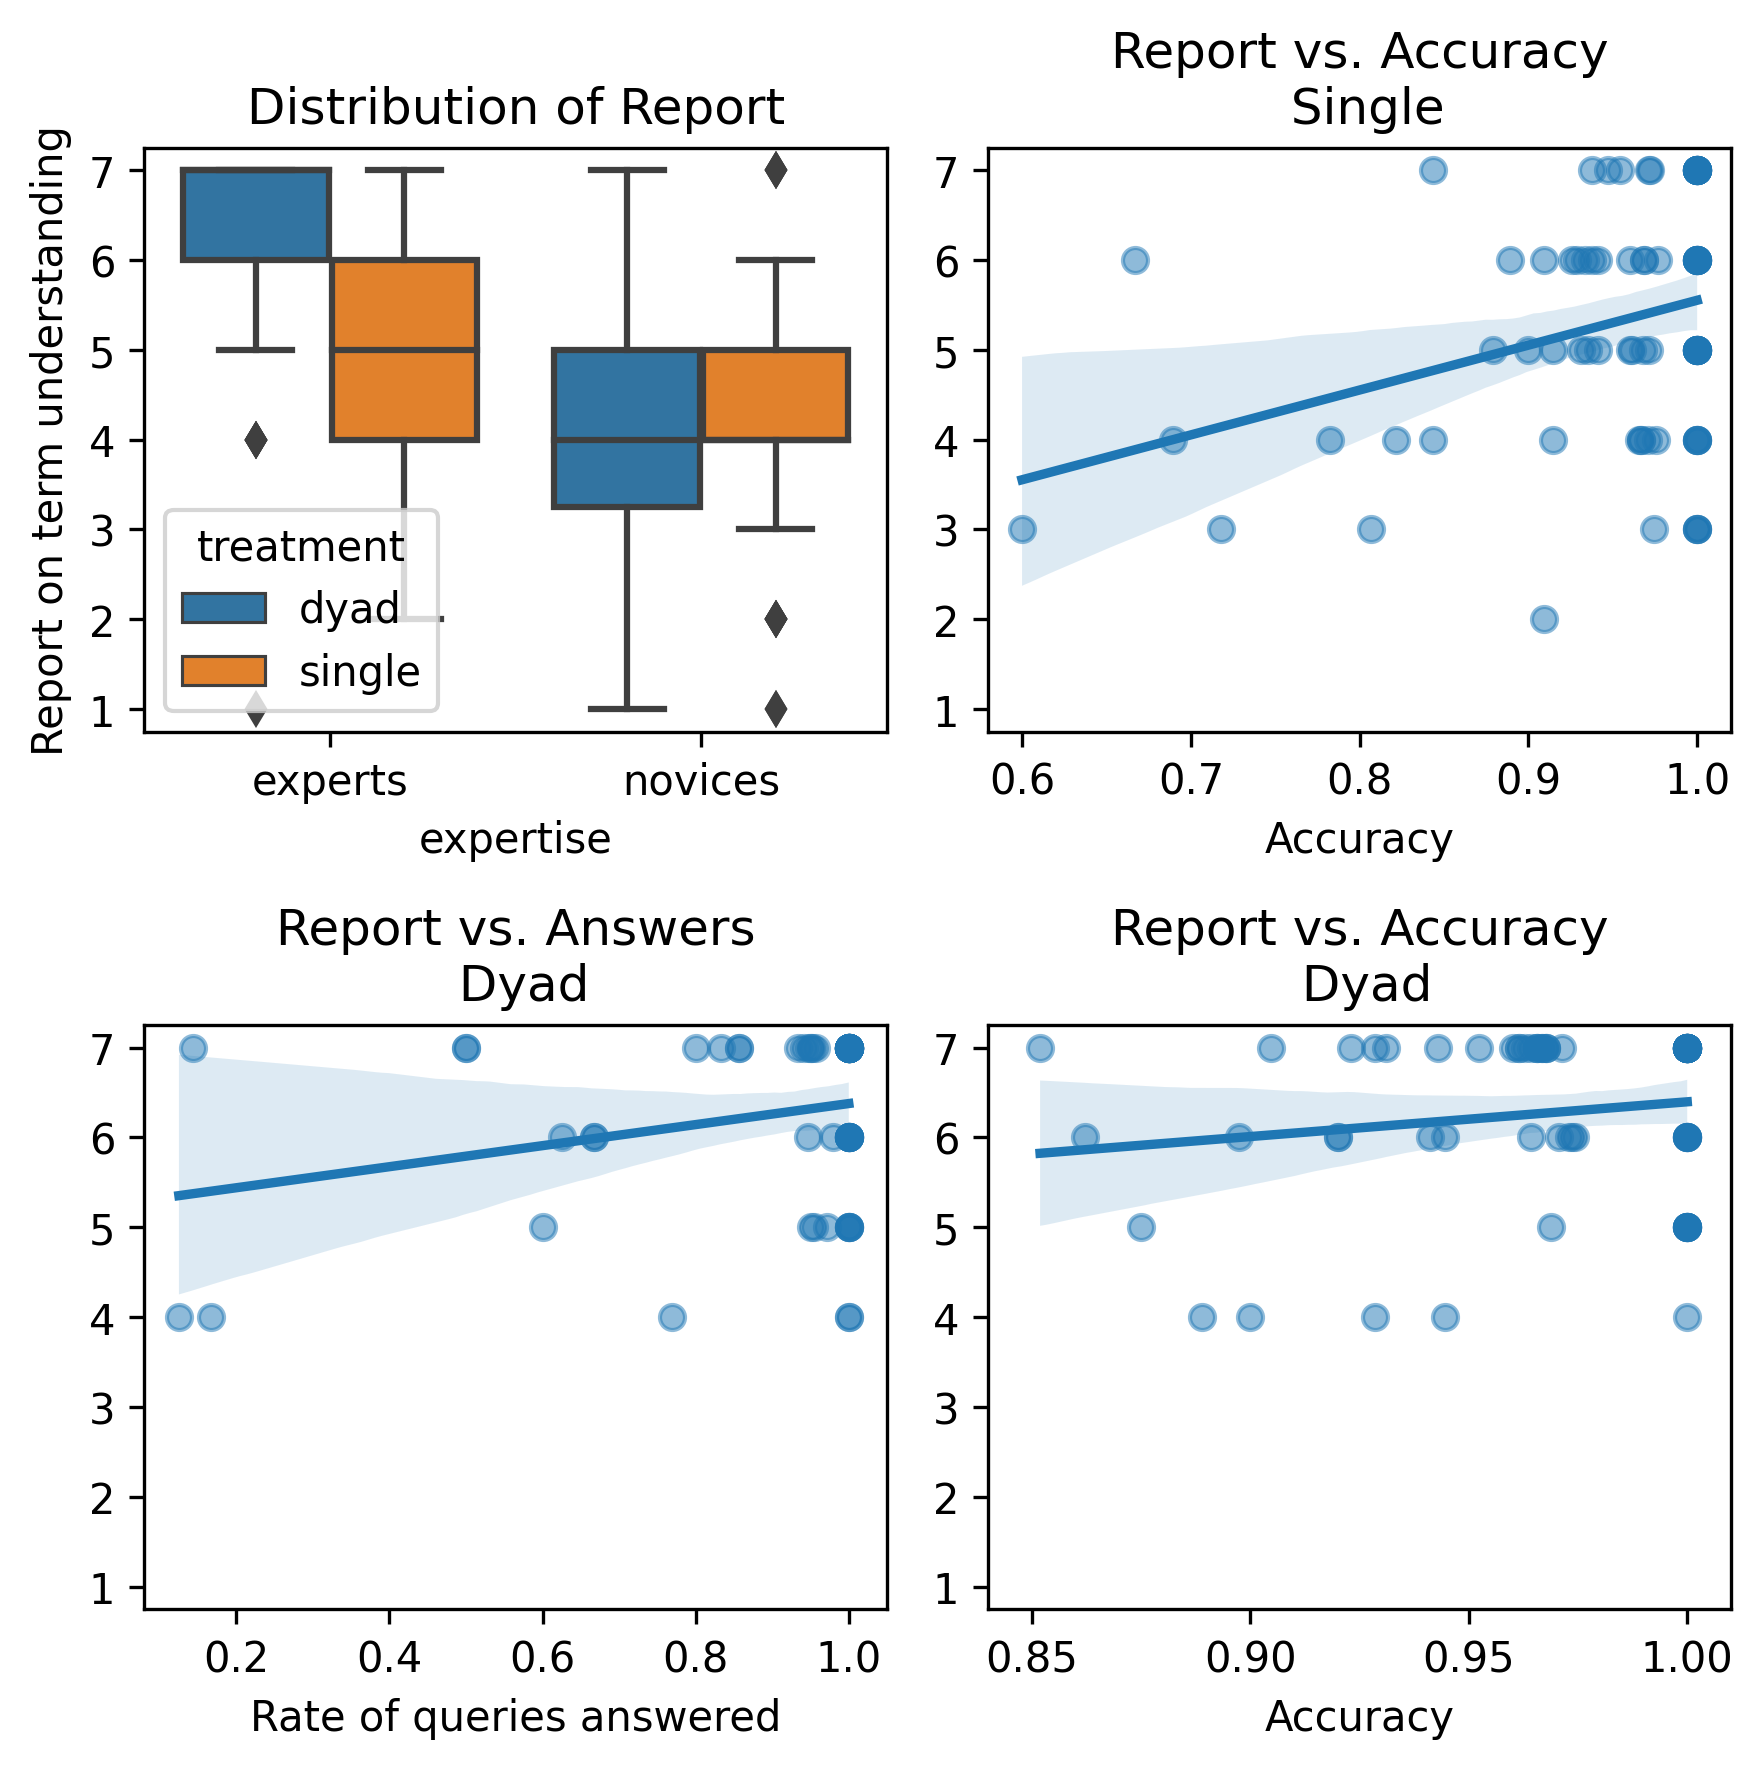

In [174]:
fig, axes = plt.subplots(2, 2, figsize=(6,6), dpi=300)
sns.boxplot(x='expertise', y='report', hue='treatment', data=reporte_comprension, ax=axes[0, 0])
sns.regplot(y='report', x='accuracy', data=reporte_comprension_expertos_individual, scatter_kws={'alpha':0.5}, ax=axes[0, 1])
sns.regplot(y='report', x='accuracy', data=reporte_comprension_expertos_parejas, scatter_kws={'alpha':0.5}, ax=axes[1, 1])
sns.regplot(y='report', x='player_responded', data=reporte_comprension_expertos_parejas, scatter_kws={'alpha':0.5}, ax=axes[1, 0])

axes[0, 0].set_title('Distribution of Report')
axes[0, 0].set_ylabel('Report on term understanding')
axes[0, 0].set(ylim=(0.75, 7.25))
axes[1, 0].set_title('Report vs. Answers\n Dyad')
axes[1, 0].set_xlabel('Rate of queries answered')
axes[1, 0].set_ylabel('')
axes[1, 0].set(xlim=(0.08, 1.05))
axes[1, 0].set(ylim=(0.75, 7.25))
axes[0, 1].set_title('Report vs. Accuracy\n Single')
axes[0, 1].set_xlabel('Accuracy')
axes[0, 1].set_ylabel('')
axes[0, 1].set(xlim=(0.58, 1.02))
axes[0, 1].set(ylim=(0.75, 7.25))
axes[1, 1].set_title('Report vs. Accuracy\n Dyad')
axes[1, 1].set_xlabel('Accuracy')
axes[1, 1].set_ylabel('')
axes[1, 1].set(xlim=(0.84, 1.01))
axes[1, 1].set(ylim=(0.75, 7.25))

fig.tight_layout()

In [175]:
fig.savefig('figura6.pdf', dpi=300)

---

**Figure 7:**

In [ ]:
df_novatos_single = reporte_comprension[(reporte_comprension['treatment']=='single') & (reporte_comprension['expertise']=='novices')]
df_novatos_parejas = reporte_comprension[(reporte_comprension['treatment']=='dyad') & (reporte_comprension['expertise']=='novices')]


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6,6), dpi=300)
sns.regplot(x='accuracy', y='report', data=df_novatos_single, scatter_kws={'alpha':0.5}, ax=axes[0,0])
sns.regplot(x='accuracy', y='report', data=df_novatos_parejas, scatter_kws={'alpha':0.5}, ax=axes[0,1])
sns.regplot(x='queried', y='report', data=df_novatos_parejas, scatter_kws={'alpha':0.5}, ax=axes[1,0])
sns.regplot(x='answered', y='report', data=df_novatos_parejas, scatter_kws={'alpha':0.5}, ax=axes[1,1])
axes[0,0].set_title('Report vs. Accuracy\n Single')
axes[0,0].set_xlabel('Accuracy')
axes[0,0].set_ylabel('')
axes[0,0].set(xlim=(0.45, 1.05))
axes[0,0].set(ylim=(0.75, 7.25))
axes[0,1].set_title('Report vs. Accuracy\n Dyad')
axes[0,1].set_xlabel('Accuracy')
axes[0,1].set_ylabel('')
axes[0,1].set(xlim=(0.45, 1.05))
#axes[0,0].set(ylim=(1, 7))

axes[1,0].set_title('Report vs. Queries\n Dyad')
axes[1,0].set_xlabel('# of dogs queried')
axes[1,0].set_ylabel('')
#axes[1,0].set(xlim=(0, 1.05))
#axes[0,1].set(ylim=(1, 7))
axes[1,1].set_title('Report vs. Answers\n Dyad')
axes[1,1].set_xlabel('Rate of queries answered')
axes[1,1].set_ylabel('')
axes[1,1].set(xlim=(0, 1.05))
#axes[0,2].set(ylim=(1, 7))

fig.tight_layout()

In [ ]:
fig.savefig('figura7.pdf', dpi=300)

---